In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import datetime
import mysql.connector
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer
import seaborn as sns

In [3]:
cnx = mysql.connector.connect(
    host="127.0.0.1",
    port=3306,
    user="root",
    password="root",
    database="pfe")

In [4]:
#Selecting the corresponding products to forecast, and store them into a pandas datafame

nature = "G"
nQuery = "select item_category_code from nature_map WHERE nature = '"+ nature +"';"

natureQuery = cnx.cursor()
natureQuery.execute(nQuery)
itemCategoryCode = natureQuery.fetchall()
extension = ""

for code in itemCategoryCode:
    c = code[0]
    extension = extension + " OR item_category_code LIKE '%"+ c +"%'"


extension = extension[3:]
query = "SELECT item_no, item_category_code ,posting_date, quantity*-1  FROM transactions WHERE entry_type LIKE '%sale%' AND (" + extension + ");"

dataCursor = cnx.cursor()
dataCursor.execute(query)
dataResults = dataCursor.fetchall()

results = pd.DataFrame(dataResults, columns = ['product', 'group', 'date', 'quantity'])
results["date"] = pd.to_datetime(results['date'])
results["group"] = results.group.apply(lambda x: re.sub(r'\W+', '', x))

results

product      group       date   quantity
0      G00176  GZ0200011 2012-03-01      3.140
1      G00745  GZ0600033 2012-03-01   6383.620
2      G00745  GZ0600033 2012-03-01  11765.580
3      G00745  GZ0600033 2012-03-01  11561.480
4      G00745  GZ0600033 2012-03-01  13184.860
...       ...        ...        ...        ...
67798  G00188  GZ0800031 2016-12-01      3.140
67799  G00188  GZ0800031 2016-12-01      3.140
67800  G00144  GZ0800031 2016-12-01      3.140
67801  G00188  GZ0800031 2016-12-01      9.420
67802  G00188  GZ0800031 2016-12-01      3.140

[67803 rows x 4 columns]

In [4]:
#Utitlity function for mapping groups to number
def mapGroups(group, groupList, inverse = False):
        
        if inverse:
            groupList[group]
        else:
            for i in range(len(groupList)):
                if groupList[i] == group:
                    return i

In [5]:
#Resample, reshape and organize the data into the dataframe

products = results.groupby("product")

groupList = results[["group"]].groupby("group").sum().index #Number of groups

index = pd.date_range(start="2012-03-04", end="2016-12-04", freq='w')
residual = pd.DataFrame({"residual" : np.zeros(len(index))}, index=index)

qtys = ["residual"]
#qtys = []

total = pd.DataFrame(index=index)


total = total.assign(Yearweek=total.index.weekofyear)
total = total.assign(Year=total.index.year)
total = total.assign(Yearday=total.index.dayofyear) 

k=0

groupsList = []

for i, g in products:
    
    product = products.get_group(i)
    
    productName = product["product"].array[0]
    productGroup = product["group"].array[0]
    
    del product["group"]
    del product["product"]
    
    product = product.groupby("date").sum()
    product = product.astype("float64")

    #roduct.resample("w").sum()["2014-12-04":"2016-12-04"].astype(bool).sum(axis=0).values[0]
    dataPoints = product.resample("w").sum()["2014-12-04":"2016-12-04"].astype(bool).sum(axis=0).values[0] #Data Points in the last two years
                                                         #If more than 10 we'll consider into our prediction
                                                         #If not I'm gonna put it in the residual column

        
    #Fill empty spots and make them same size
    product = product.resample('w').sum().reindex(index).fillna(0)    
    product["quantity"] = product["quantity"].apply(lambda x: 0.0 if x<0 else x) 
    
    
    if(dataPoints < 20):
        residual = residual.add(product.values)
    else:
        qtColName = productName + "_qty"
        ctColName = productName+ "_group"
        groupsList.append(mapGroups(productGroup, groupList))
        
        tempDf = pd.DataFrame(
            {qtColName: product["quantity"]
             ,ctColName: mapGroups(productGroup, groupList)
            })
            
        
        total = pd.concat([total, tempDf], axis=1, sort=False)
        
        qtys.append(qtColName)

total = pd.concat([total, residual], axis=1, sort=False)

In [6]:
#Calculating baseline error to refer to it later on to measure the success of the model (walk forward model)

products_2 = results.groupby("product")
from sklearn.metrics import mean_squared_error

index = pd.date_range(start="2012-03-04", end="2016-12-04", freq='w')

prods = []
for i in range(1,len(qtys)):
    prods.append(qtys[i][:-4])
    
t = 0
k=0

naive = {}

for i, g in products_2:
    
    product = products_2.get_group(i)
    prod= product["product"].array[0]
    product = product.groupby("date").sum()
    
    
    
    del product["group"]
    del product["product"]
    
    product = product.resample('w').sum().reindex(index).fillna(0)    
    product["quantity"] = product["quantity"].apply(lambda x: 0.0 if x<0 else x) 
    
    coef = 0.8
    delimiter = int((1-coef) *index.shape[0])
    
    validate = product.tail(delimiter)
    
    prediction = product[index.shape[0] - delimiter*2:index.shape[0] - delimiter]

    if(prod in prods):
        rmse = np.sqrt(mean_squared_error(prediction.values.astype("float"), validate.values.astype("float")))
        naive[prod] = rmse
        
        t = t + rmse
        k = k + 1
        
        
naive["total"] = t/k

In [7]:
batch_size = 119  #For GPU workload

input_seq_len = 15 
target_seq_len = 15

#Some other parameter might be dense layer oreder

name = "LSTMCells512_GRU_full_linear_sigmoid"
product = total

product


Yearweek  Year  Yearday  G00005_qty  G00005_group  G00006_qty  \
2012-03-04         9  2012       64     1676.76             1     1029.92   
2012-03-11        10  2012       71        0.00             1        0.00   
2012-03-18        11  2012       78        0.00             1        0.00   
2012-03-25        12  2012       85        0.00             1        0.00   
2012-04-01        13  2012       92     1761.54             1      872.92   
...              ...   ...      ...         ...           ...         ...   
2016-11-06        44  2016      311     1177.50             1      602.88   
2016-11-13        45  2016      318        0.00             1        0.00   
2016-11-20        46  2016      325        0.00             1        0.00   
2016-11-27        47  2016      332        0.00             1        0.00   
2016-12-04        48  2016      339     1142.96             1      681.38   

            G00006_group  G00008_qty  G00008_group  G00009_qty  ...  \
2012-03-04             1    15533.58             1     2056.70  ...   
2012-03-11             1        0.00             1        3.14  ...   
2012-03-18             1        0.00             1       12.56  ...   
2012-03-25             1        0.00             1        0.00  ...   
2012-04-01             1    12189.48             1     1708.16  ...   
...                  ...         ...           ...         ...  ...   
2016-11-06             1     9401.16             1      904.32  ...   
2016-11-13             1        0.00             1        0.00  ...   
2016-11-20             1        0.00             1        0.00  ...   
2016-11-27             1        0.00             1        0.00  ...   
2016-12-04             1    10889.52             1     1086.44  ...   

            G00760_group  G00770_qty  G00770_group  G00771_qty  G00771_group  \
2012-03-04             5      260.62             1      150.72             3   
2012-03-11             5        0.00             1        0.00             3   
2012-03-18             5        3.14             1        0.00             3   
2012-03-25             5        0.00             1        0.00             3   
2012-04-01             5      348.54             1      204.10             3   
...                  ...         ...           ...         ...           ...   
2016-11-06             5      392.50             1      131.88             3   
2016-11-13             5        0.00             1        0.00             3   
2016-11-20             5        0.00             1        0.00             3   
2016-11-27             5        0.00             1        0.00             3   
2016-12-04             5      483.56             1      128.74             3   

            G00954_qty  G00954_group  G00969_qty  G00969_group    residual  
2012-03-04        0.00            14        0.00            15    7856.280  
2012-03-11        0.00            14        0.00            15       3.140  
2012-03-18        0.00            14        0.00            15       0.000  
2012-03-25        0.00            14        0.00            15    7394.700  
2012-04-01        6.28            14        0.00            15  116114.063  
...                ...           ...         ...           ...         ...  
2016-11-06        9.42            14       50.24            15   30759.439  
2016-11-13        0.00            14        0.00            15       0.000  
2016-11-20        0.00            14        0.00            15       0.000  
2016-11-27        0.00            14        0.00            15       0.000  
2016-12-04        6.28            14       50.24            15   11027.680  

[249 rows x 148 columns]

In [8]:
target = product[qtys]

x_data = product.values #trimming the end of the serie because of the nan values resulted from the shift
y_data = target.values

print(x_data.shape)
print(y_data.shape)


(249, 148)
(249, 73)


In [9]:
#Reshaping the data 

data_count = len(x_data)
train_split = 0.8

num_train = int(train_split * data_count)
num_test = data_count - num_train

#Creating the test and the train data
x_train = x_data[:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

print(x_train.shape)
print(y_train.shape)
print()
print(x_test.shape)
print(y_test.shape)

(199, 148)
(199, 73)

(50, 148)
(50, 73)


In [10]:
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

print(x_train.min())

0.0


In [11]:
from sklearn.preprocessing import MaxAbsScaler

x_scaler = MaxAbsScaler() #Normalize the data
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MaxAbsScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(y_train_scaled.shape)
print(y_test_scaled.shape)
print(x_train_scaled.shape)
print(x_test_scaled.shape)

(199, 73)
(50, 73)
(199, 148)
(50, 148)


In [12]:
def batch_generator(batch_size, input_seq_len, target_seq_len):
    """
    Generator function for creating random batches of training-data.
    """

    while True:

        x_shape = (batch_size, input_seq_len, num_x_signals)
        y_shape = (batch_size, target_seq_len, num_y_signals)
        
        encoder_input = np.zeros(shape=x_shape, dtype=np.float16)
        decoder_output = np.zeros(shape=y_shape, dtype=np.float16)
        decoder_input = np.zeros(shape=y_shape, dtype=np.float16)
        
        total_length = input_seq_len + target_seq_len

        for i in range(batch_size):

            idx = np.random.randint(num_train - total_length)

            encoder_input[i] = x_train_scaled[idx:idx+input_seq_len]
            decoder_output[i] = y_train_scaled[idx+input_seq_len:idx+total_length]
        
        yield ([encoder_input, decoder_input], decoder_output)

In [13]:
generator = batch_generator(batch_size=batch_size,
                            input_seq_len=input_seq_len, target_seq_len=target_seq_len)


In [14]:
validation_data = ([np.expand_dims(x_test_scaled[:input_seq_len], axis=0), np.zeros(shape=(1, target_seq_len, num_y_signals), dtype=np.float16)],
                   np.expand_dims(y_test_scaled[input_seq_len:input_seq_len+target_seq_len], axis=0))

In [15]:
import tensorflow.keras as keras

/home/marox/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marox/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marox/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/marox/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [16]:
layers = [85,85,85]
regulariser = None

encoder_inputs = keras.layers.Input(shape=(None, num_x_signals))

encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

encoder_states = encoder_outputs_and_states[1:]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
decoder_inputs = keras.layers.Input(shape=(None, num_y_signals))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons))
    
decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

decoder_outputs = decoder_outputs_and_states[0]

decoder_dense = keras.layers.Dense(num_y_signals, activation='linear')

decoder_outputs = decoder_dense(decoder_outputs)

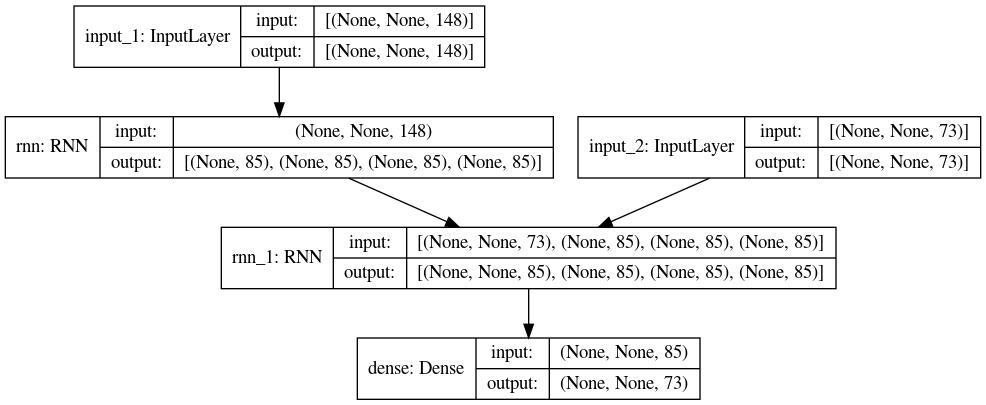

In [18]:
learning_rate = 0.001245496180919558
optimiser = keras.optimizers.Adam(lr=learning_rate)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss="mse")

keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 148)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
rnn (RNN)                       [(None, 85), (None,  146880      input_1[0][0]                    
__________________________________________________________________________________________________
rnn_1 (RNN)                     [(None, None, 85), ( 127755      input_2[0][0]                    
                                                                 rnn[0][1]                    

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-3,
                                       patience=0,
                                       verbose=1)
    
path_checkpoint = 'checks/checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callbacks = [callback_early_stopping, callback_reduce_lr, callback_checkpoint]

In [21]:
model.fit_generator(generator, steps_per_epoch=37,epochs=50, validation_data=validation_data, callbacks=callbacks)

Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
36/37 [============================>.] - ETA: 0s - loss: 0.0622
Epoch 00001: val_loss improved from inf to 0.04712, saving model to checks/checkpoint.keras
37/37 [==============================] - 26s 701ms/step - loss: 0.0621 - val_loss: 0.0471
Epoch 2/50
36/37 [============================>.] - ETA: 0s - loss: 0.0570
Epoch 00002: val_loss improved from 0.04712 to 0.04564, saving model to checks/checkpoint.keras
37/37 [==============================] - 3s 71ms/step - loss: 0.0570 - val_loss: 0.0456
Epoch 3/50
36/37 [============================>.] - ETA: 0s - loss: 0.0548
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00003: val_loss did not improve from 0.04564
37/37 [==============================] - 3s 87ms/step - loss: 0.0548 - val_loss: 0.0459
Epoch 4/50
36/37 [============================>.] - ETA: 0s - loss: 0.0513
Epoch 00004: val_loss improved from 

In [22]:
#second optimal 0.01, 0.001 RMSprop

try:
    model.load_weights("best_model.h5")
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
    

result = model.evaluate(validation_data[0], validation_data[1])

Error trying to load checkpoint.
Layer #0 (named "rnn" in the current model) was found to correspond to layer rnn in the save file. However the new layer rnn expects 9 weights, but the saved weights have 6 elements.
1/1 [==============================] - 0s 19ms/sample - loss: 0.0222


In [23]:
print("model.keras")

model.keras


In [24]:
encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

for hidden_neurons in layers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs, training=True)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

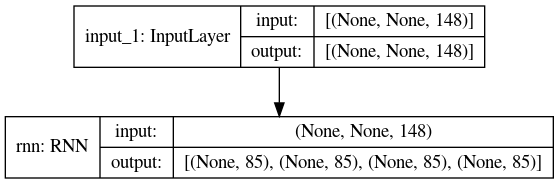

In [25]:
keras.utils.plot_model(encoder_predict_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

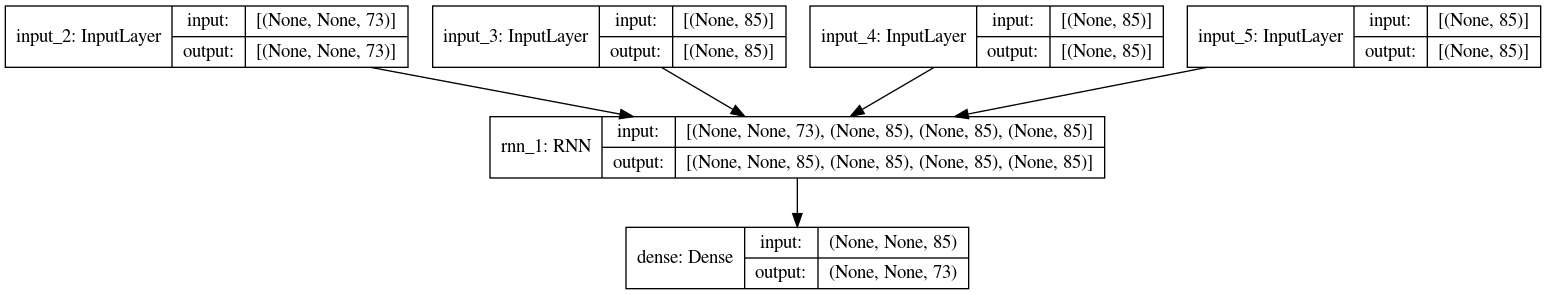

In [26]:
keras.utils.plot_model(decoder_predict_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    plt.plot(states[0][0])
    plt.plot(states[1][0])
    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, num_y_signals))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=1)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)
    

(1, 15, 148)


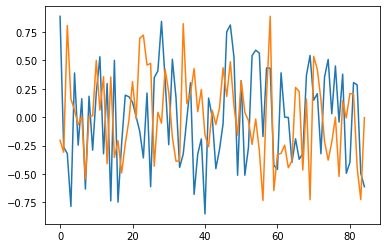

In [28]:
horizon = 50

X_for_pred = np.expand_dims(x_train_scaled[x_train_scaled.shape[0]-input_seq_len:], axis=0)

print(X_for_pred.shape)
y_test_predicted = predict(X_for_pred, encoder_predict_model, decoder_predict_model, horizon)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
def smape(x, y):
            
    sm = 0
    for i in range(len(x)):
        a = (np.abs(x[i])+np.abs(y[i]))
        if a == 0:
            a = 0.00001
            
        sm = sm + np.abs(x[i] - y[i])/(a/2)
        #print(sm)
        
    return sm/len(x)


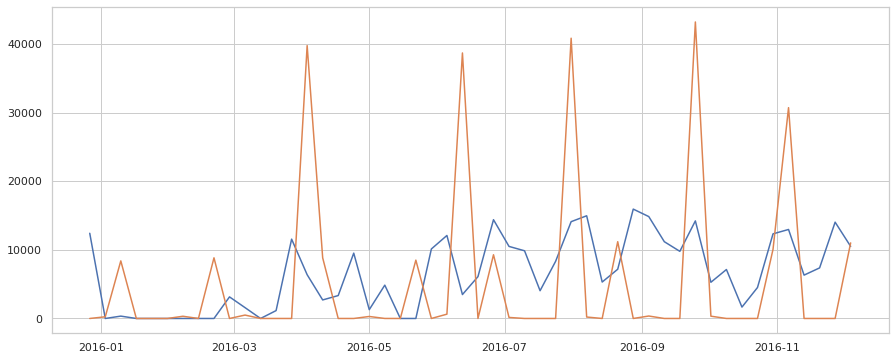

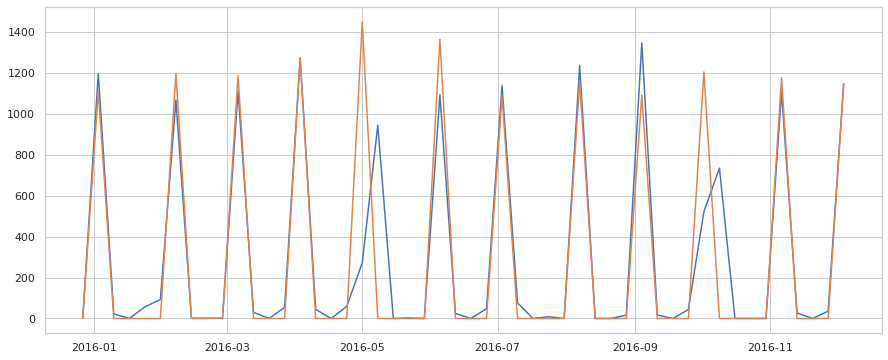

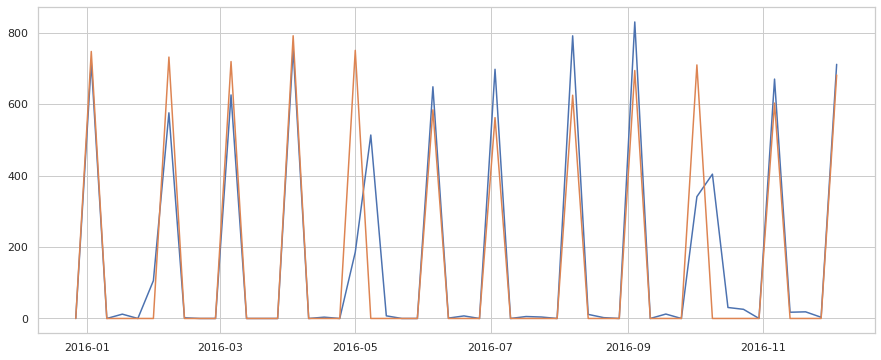

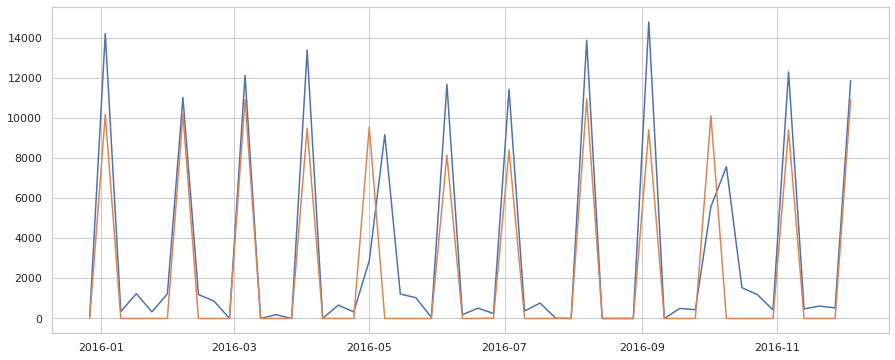

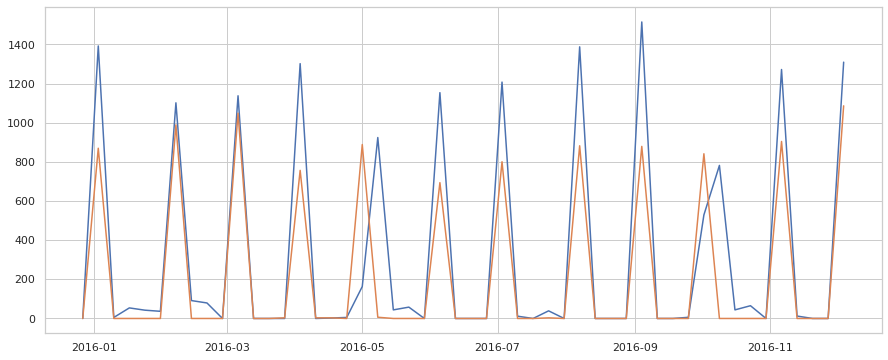

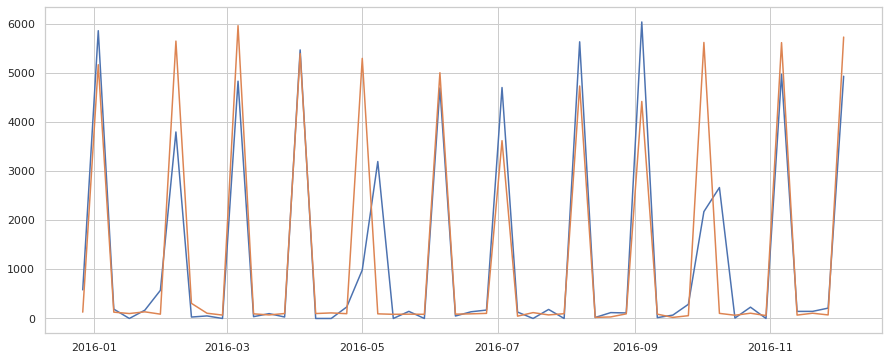

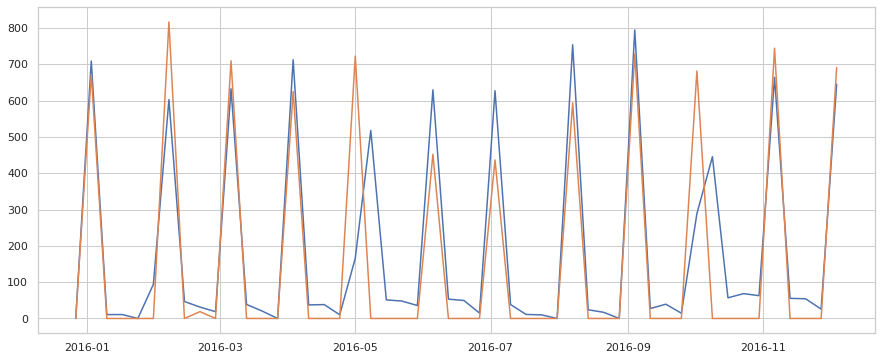

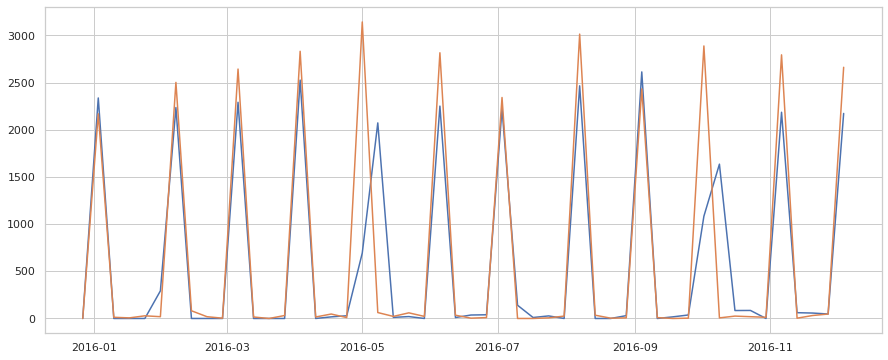

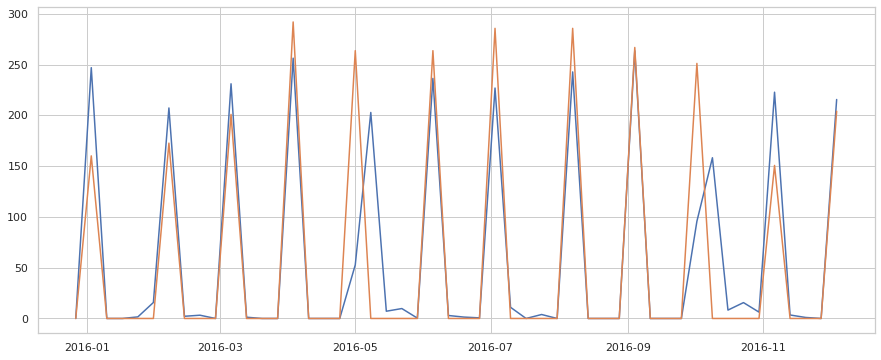

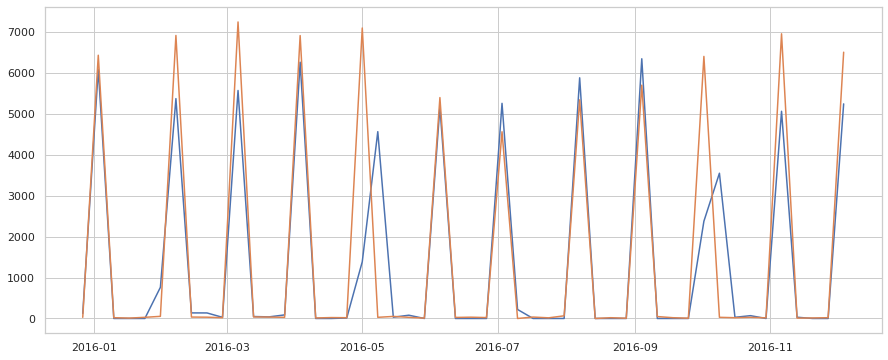

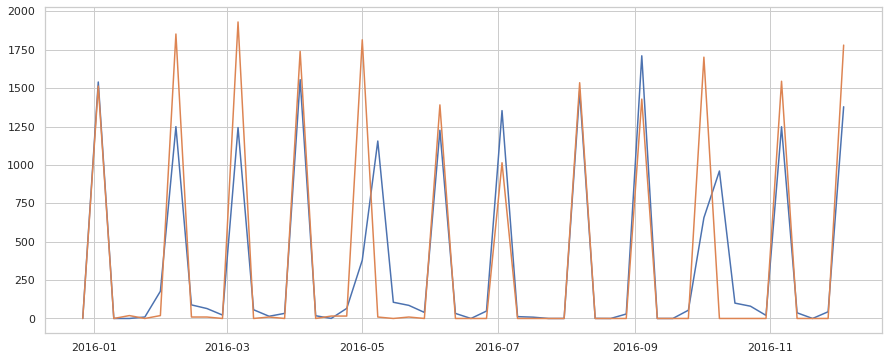

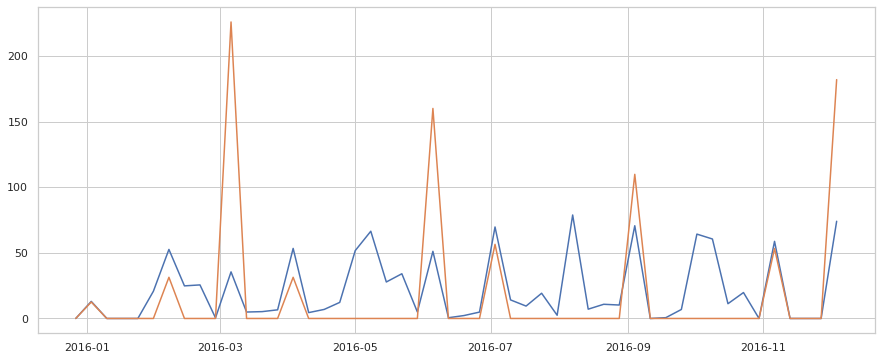

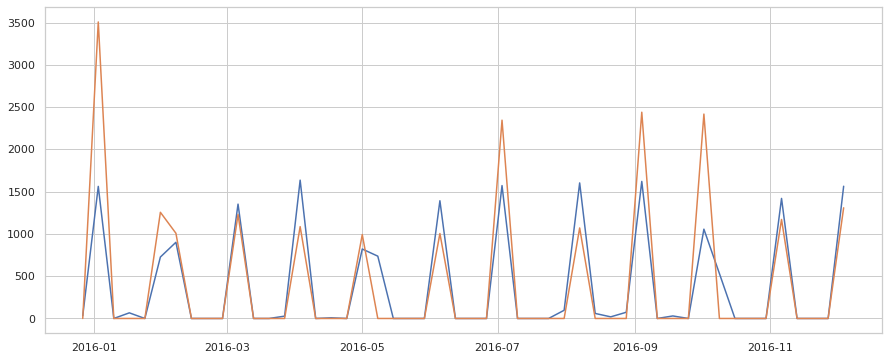

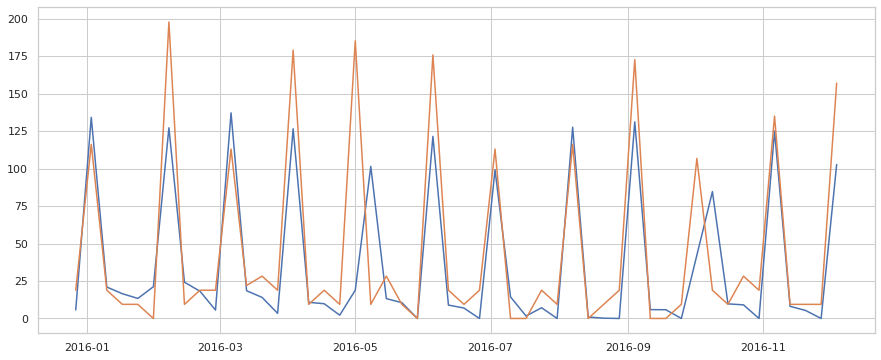

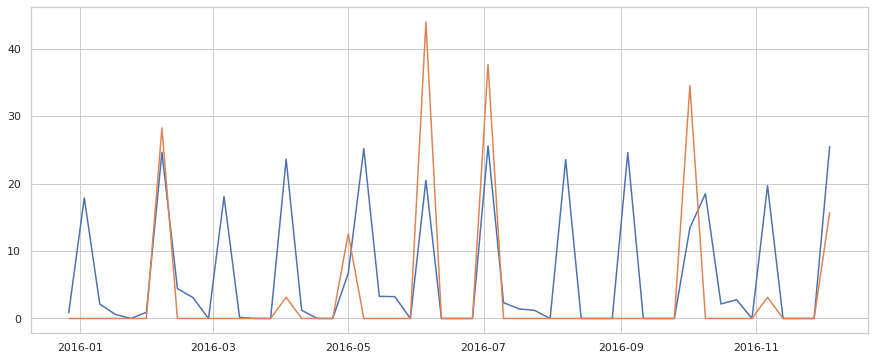

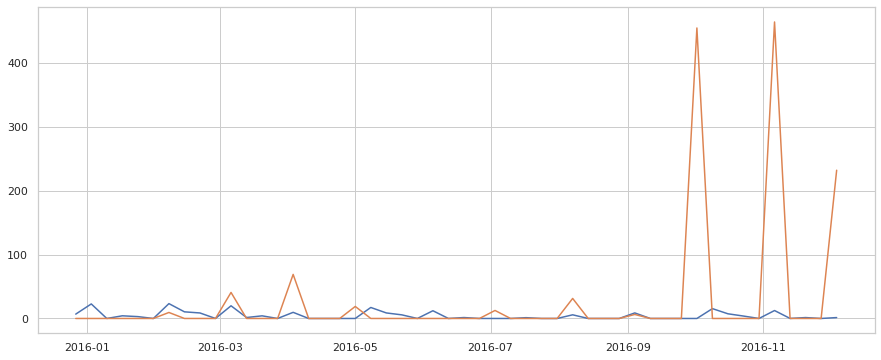

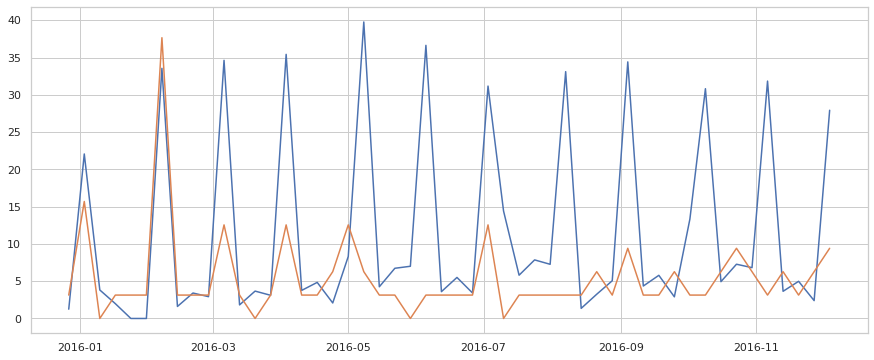

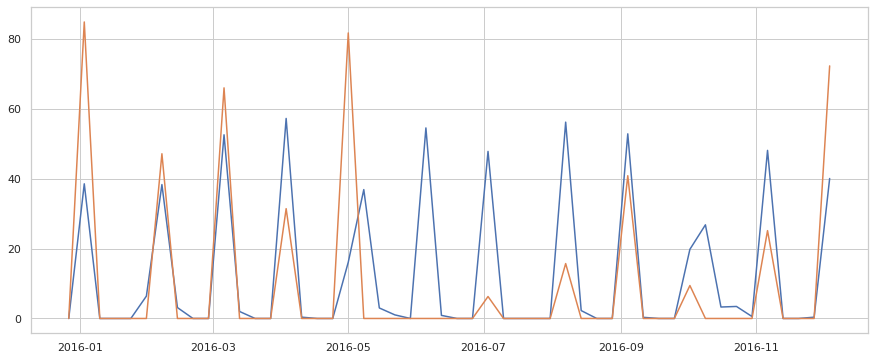

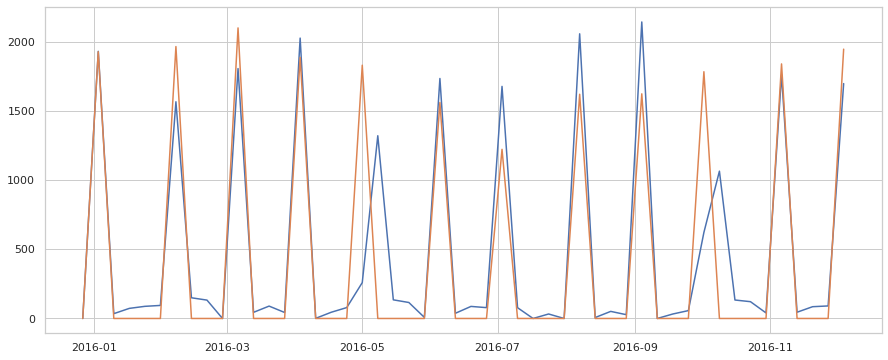

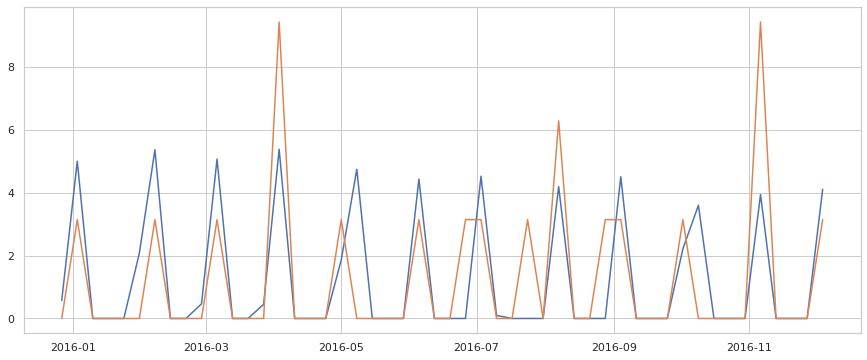

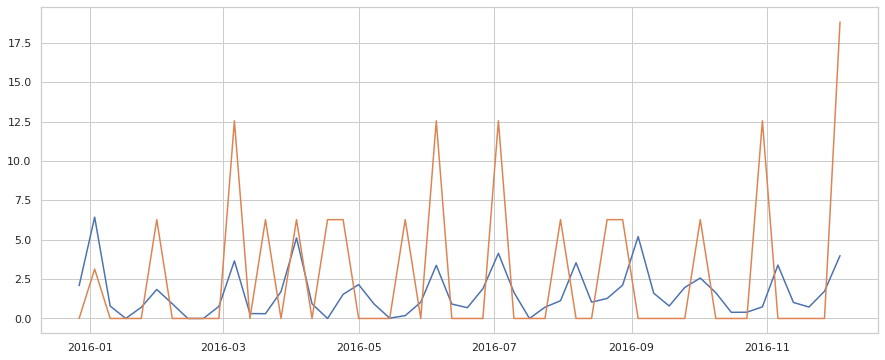

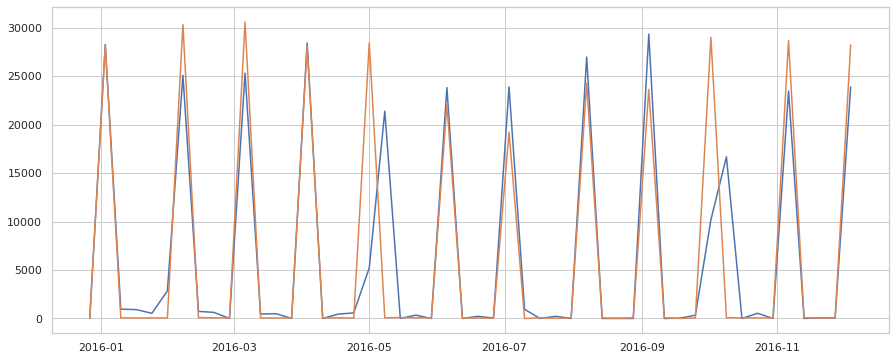

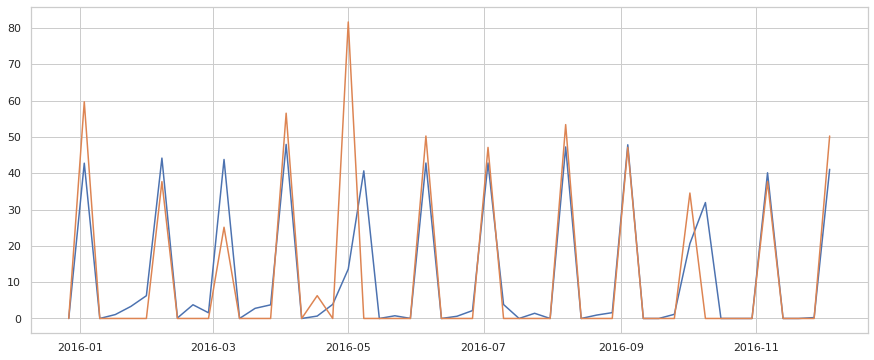

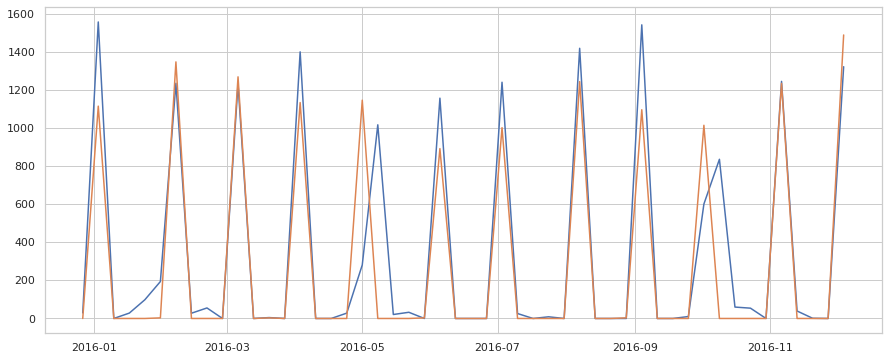

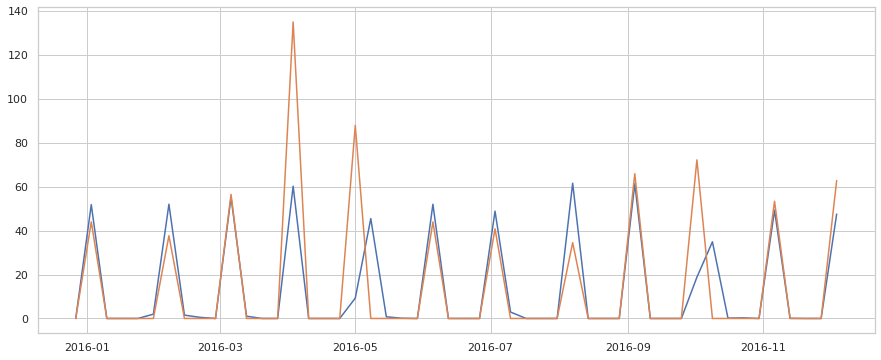

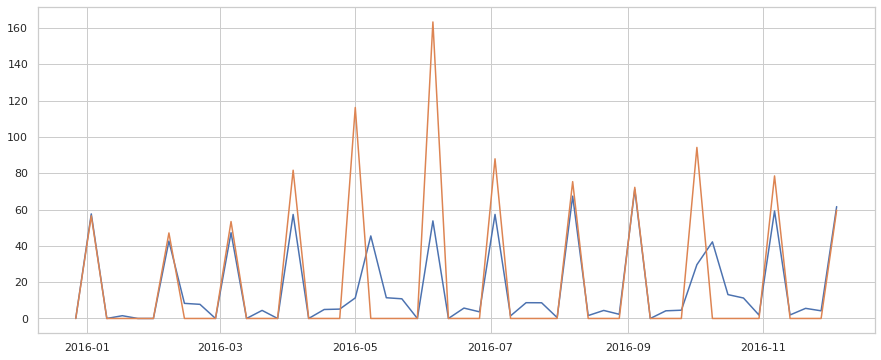

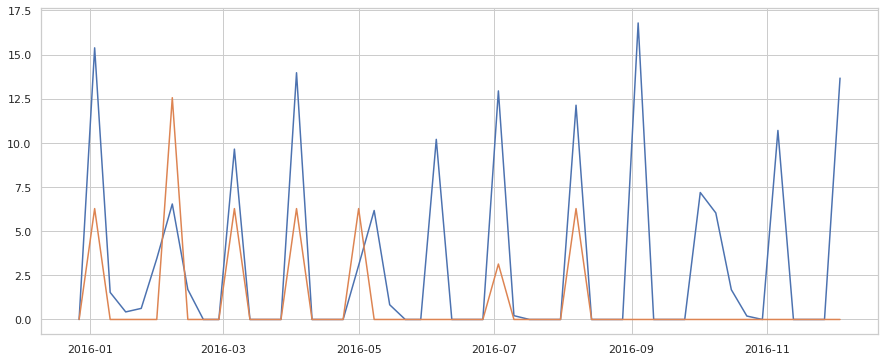

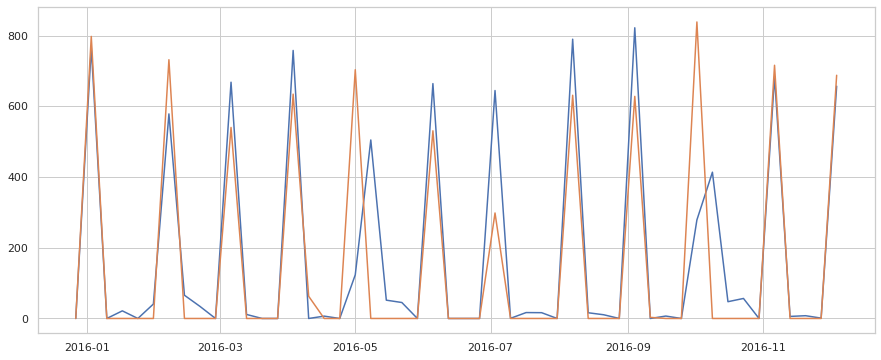

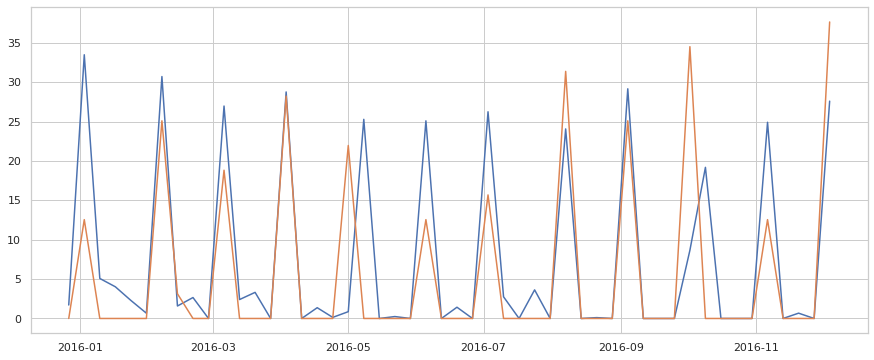

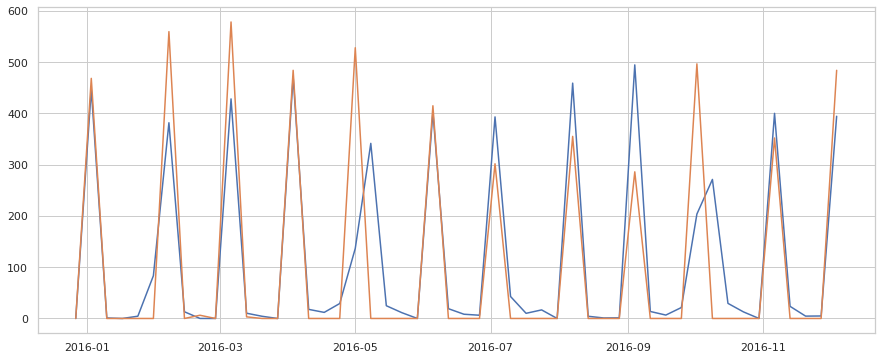

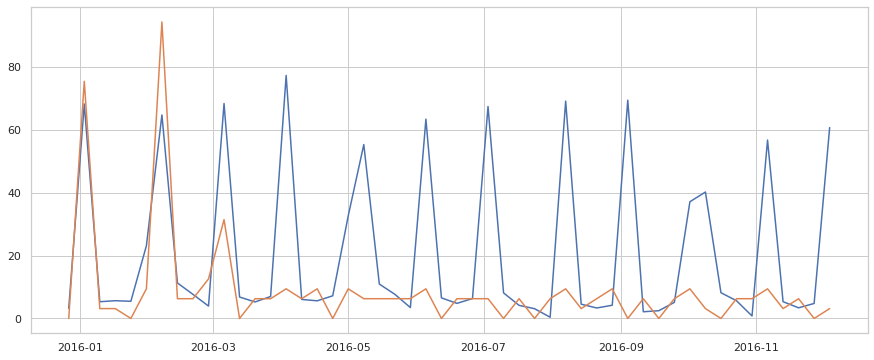

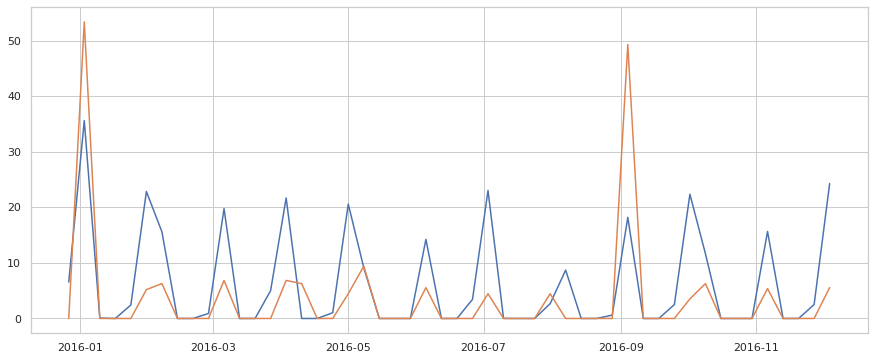

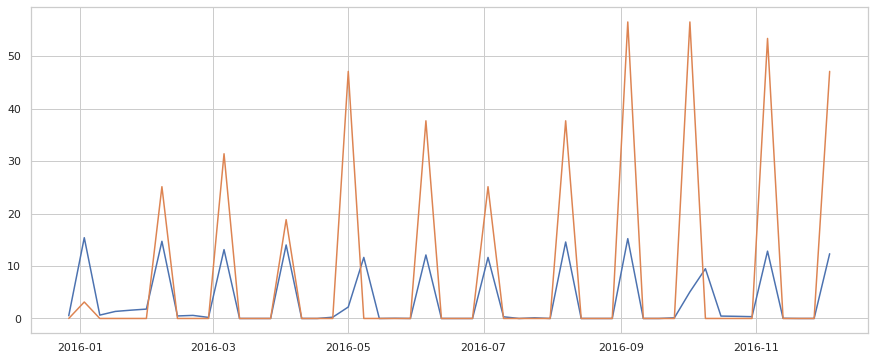

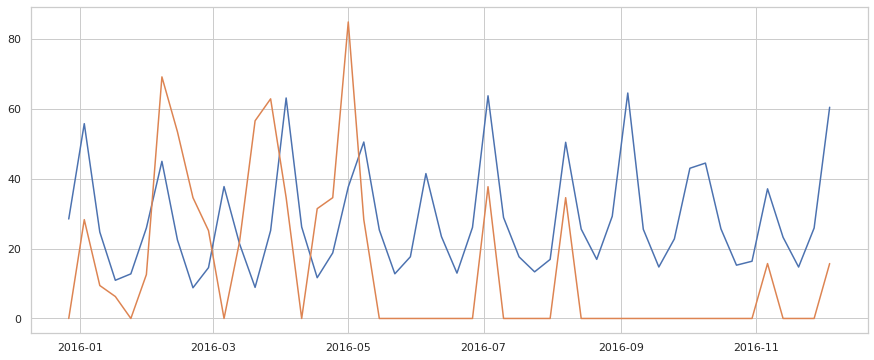

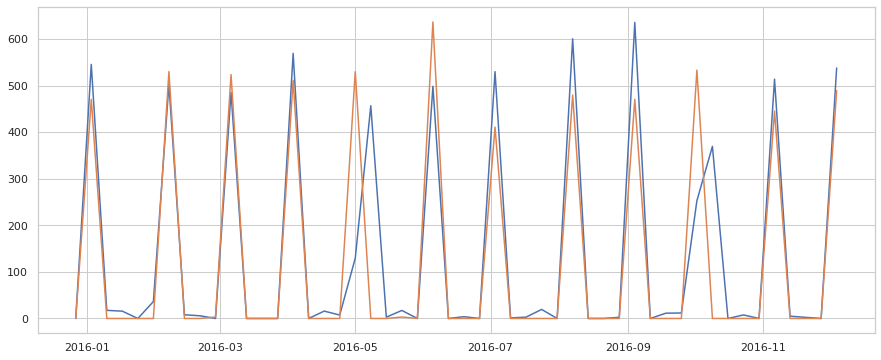

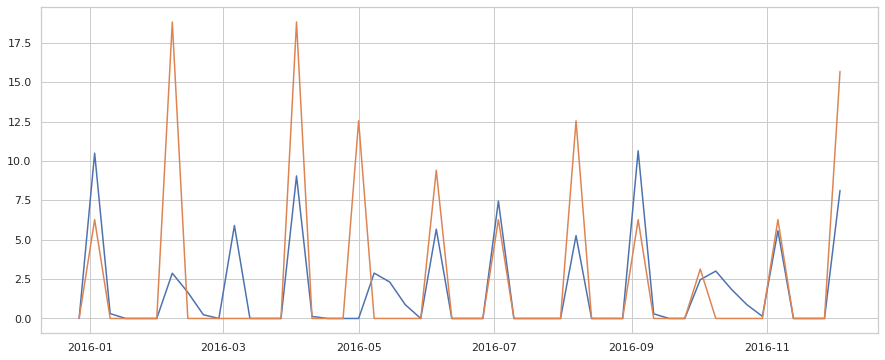

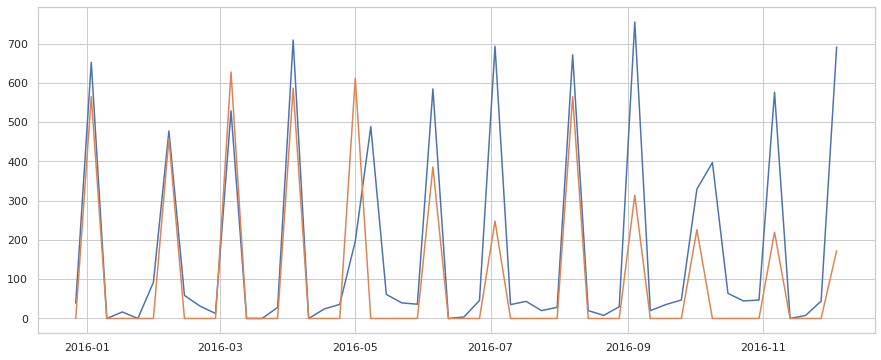

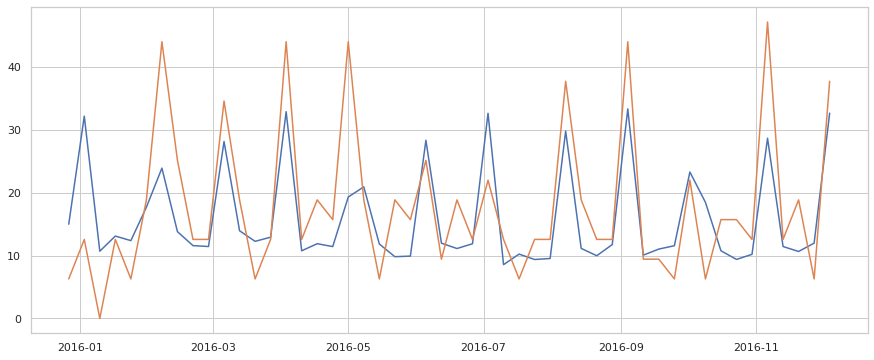

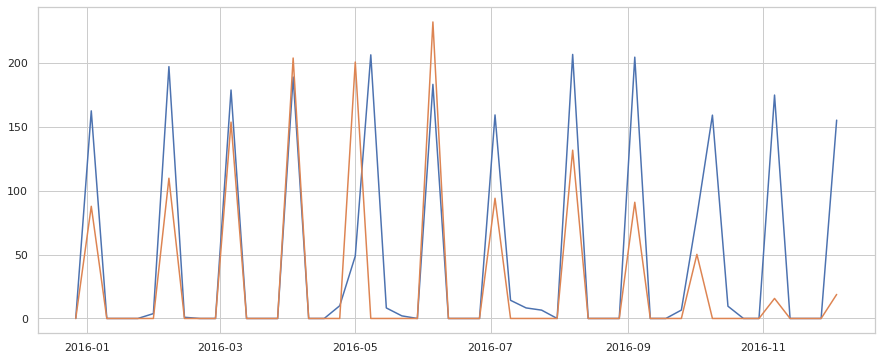

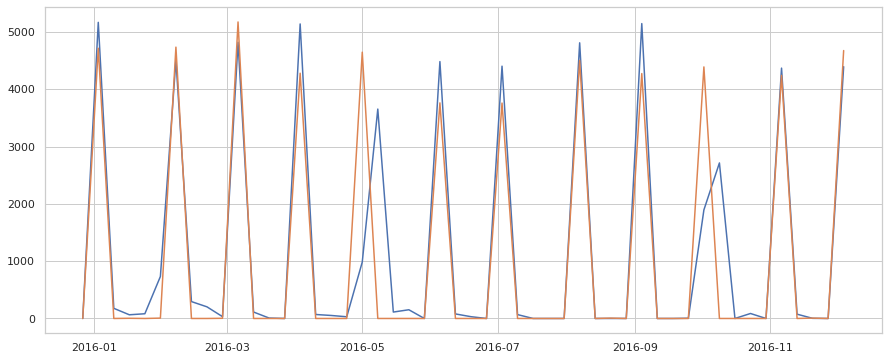

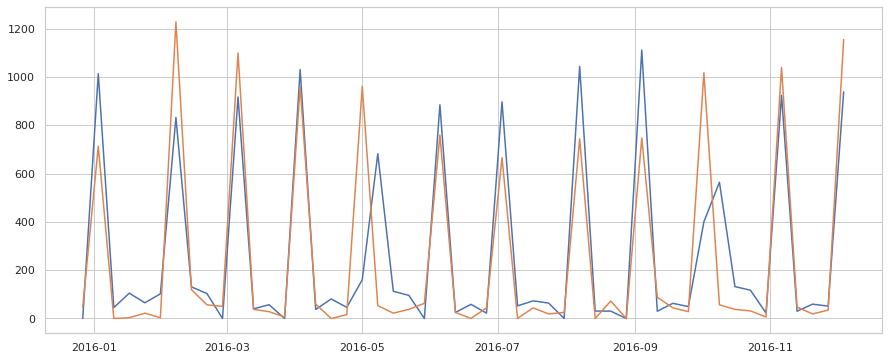

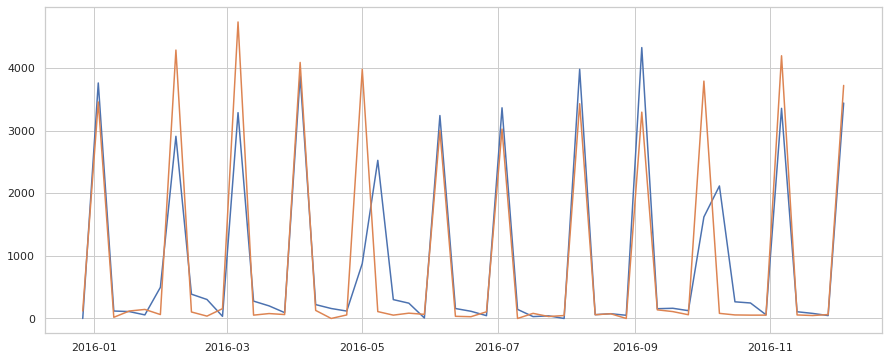

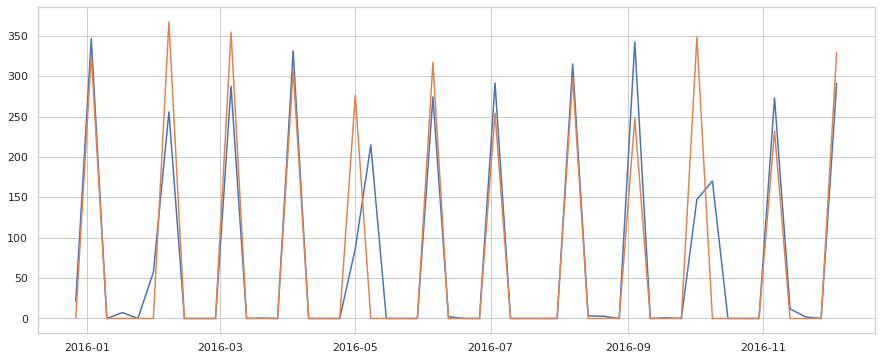

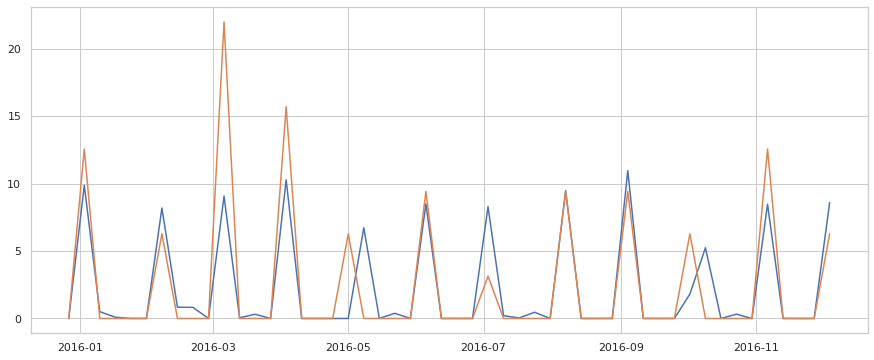

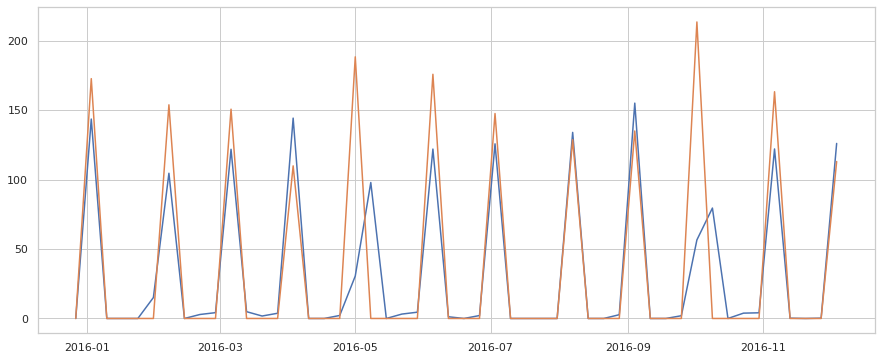

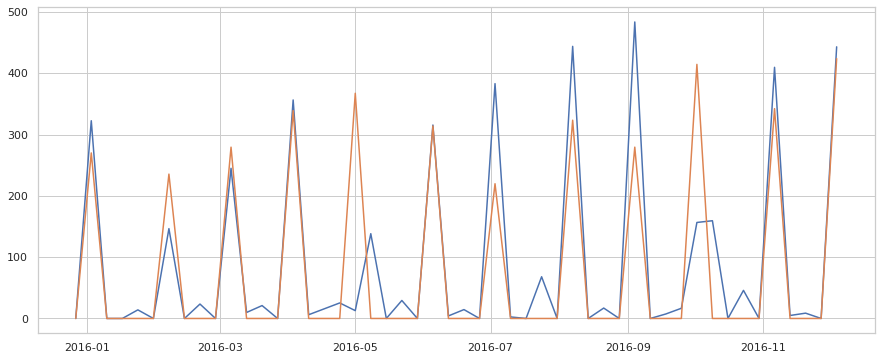

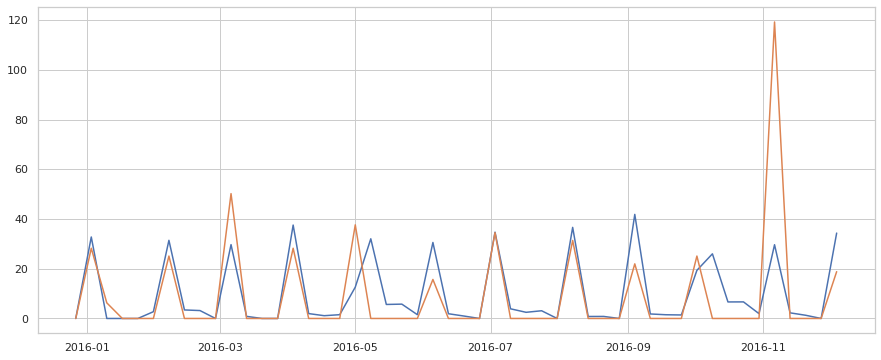

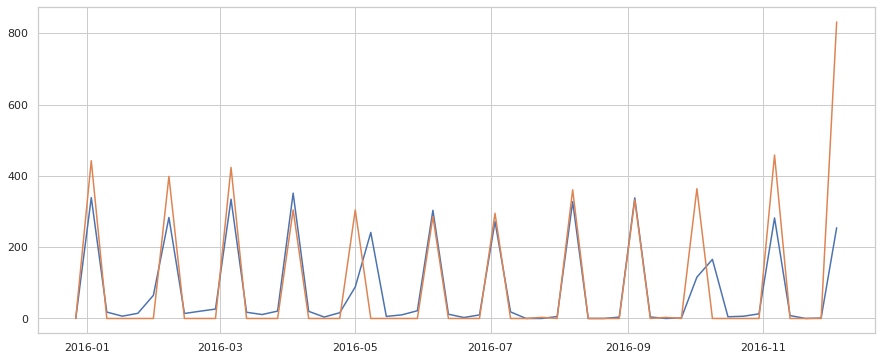

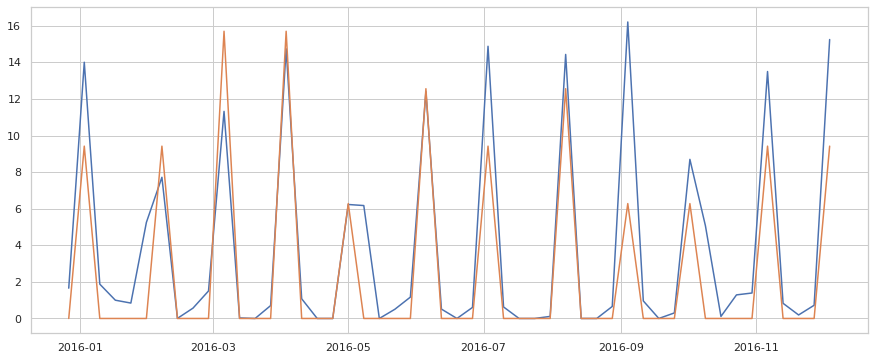

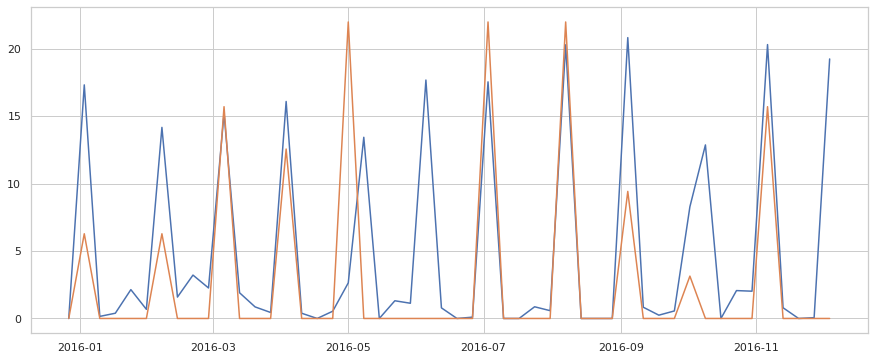

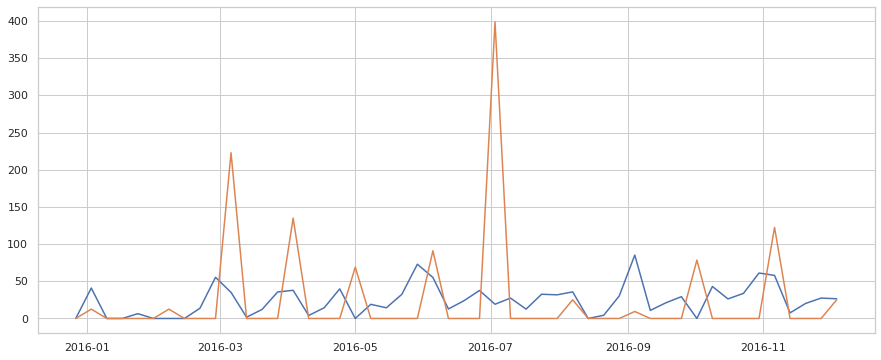

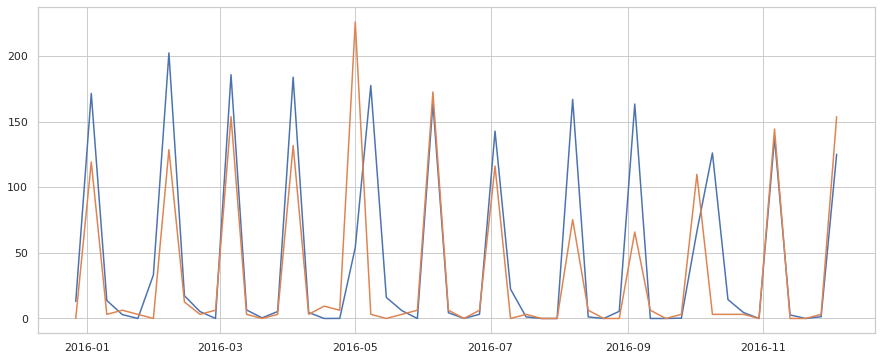

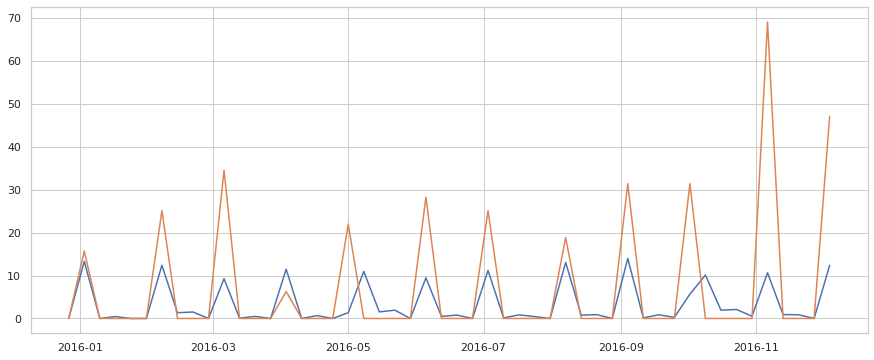

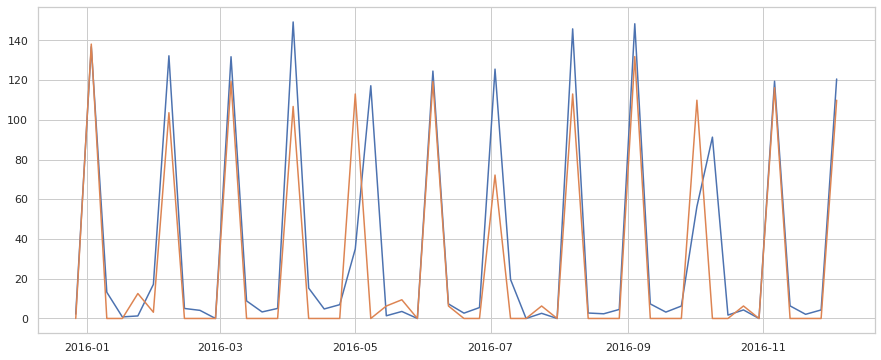

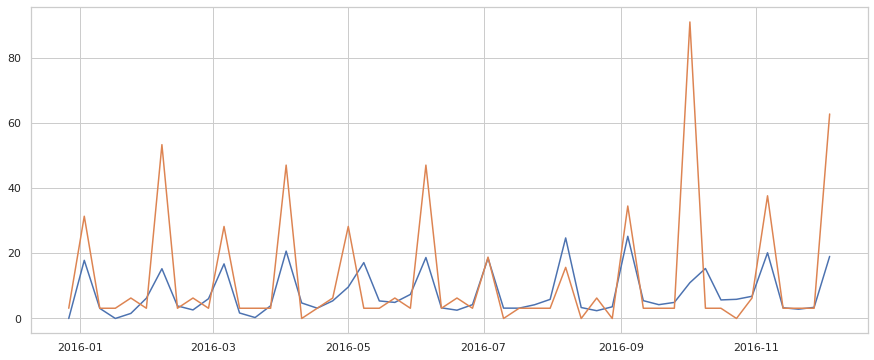

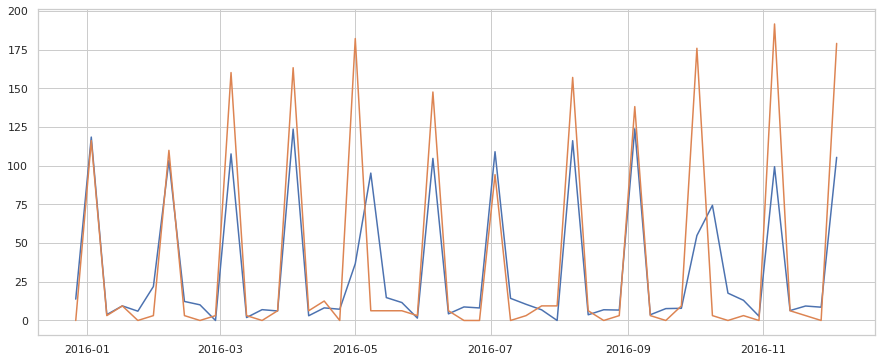

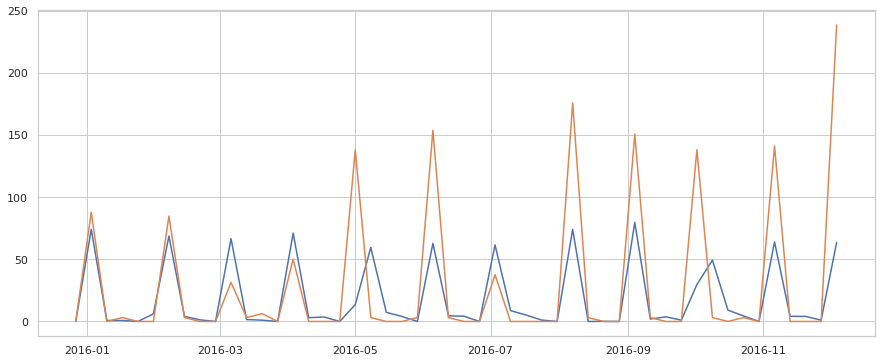

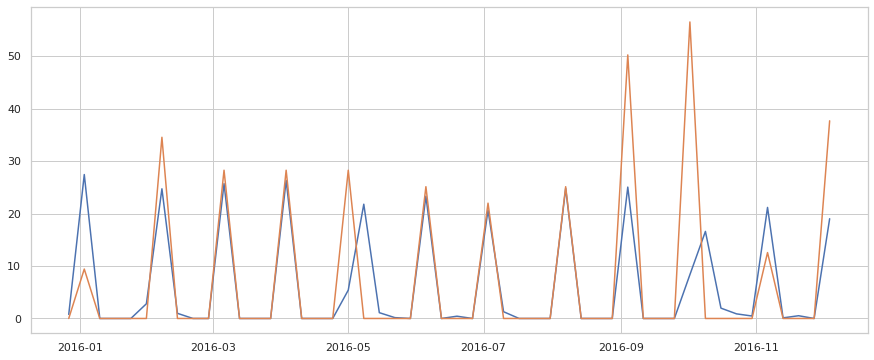

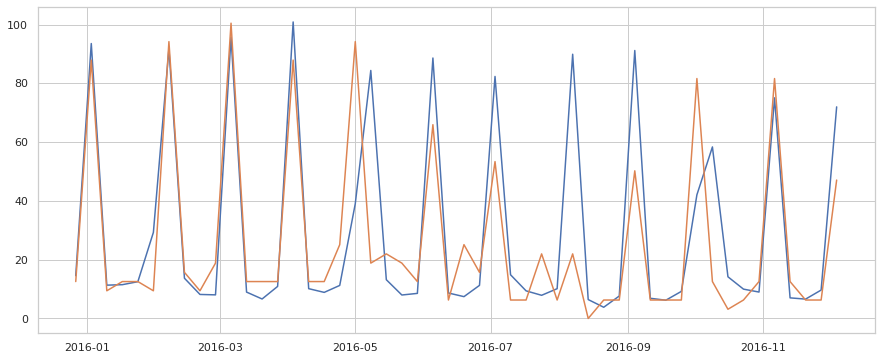

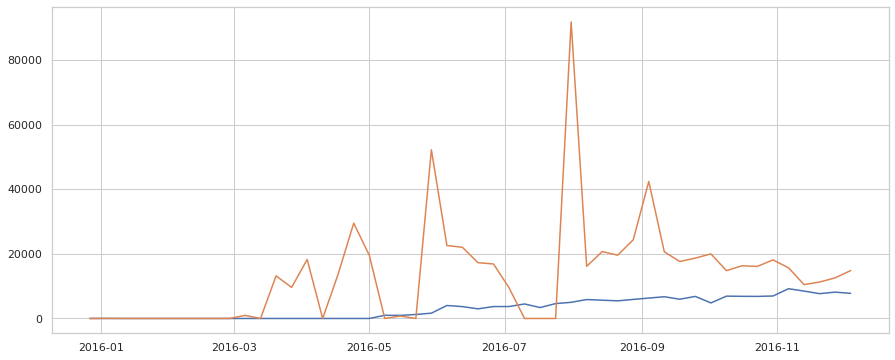

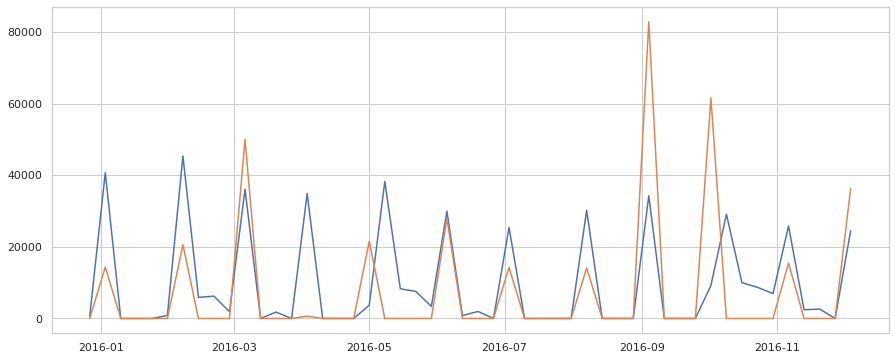

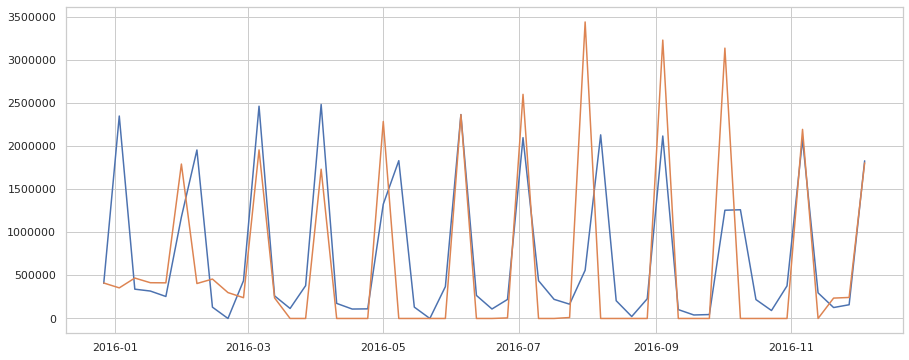

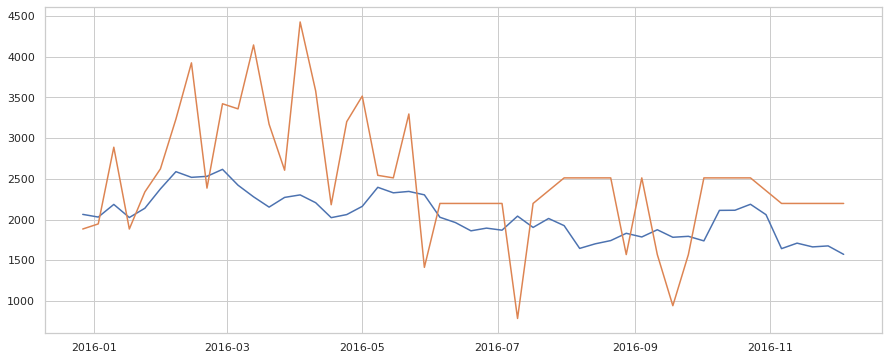

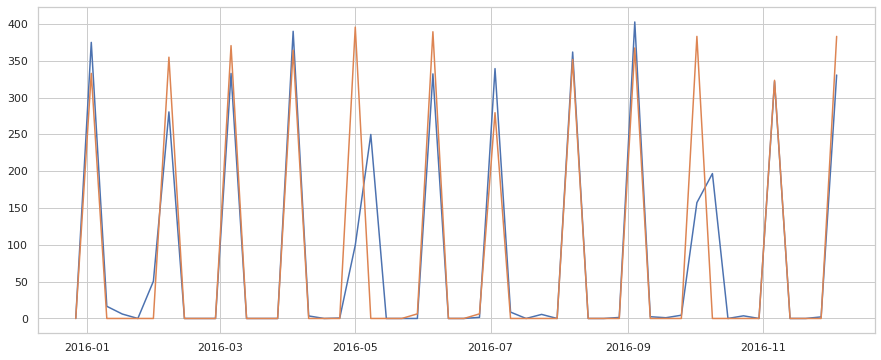

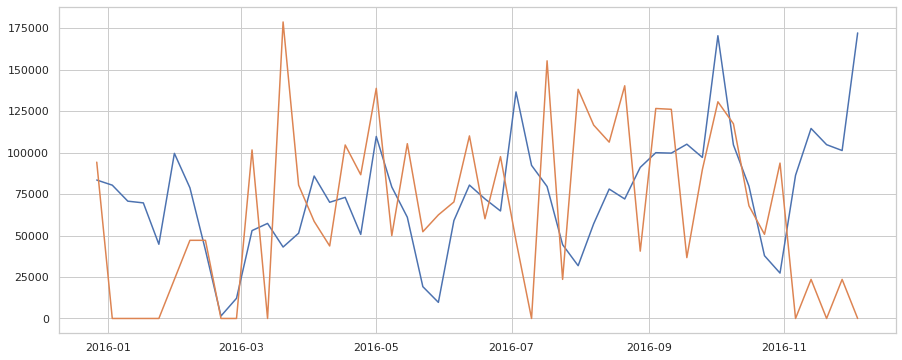

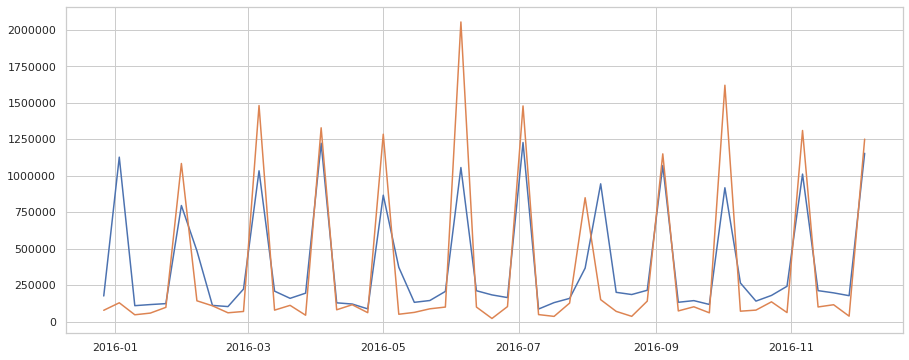

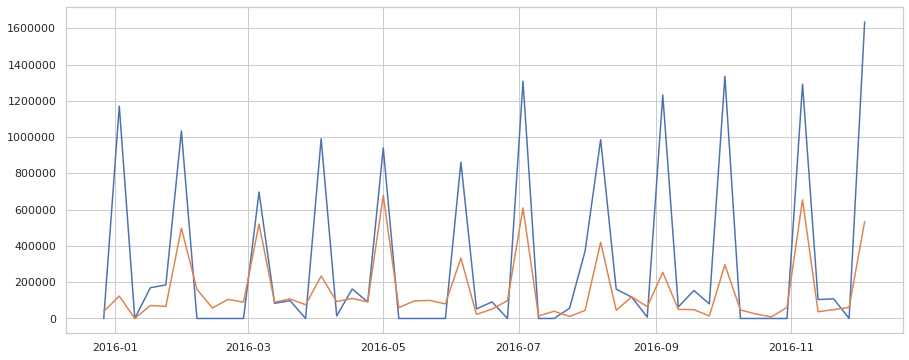

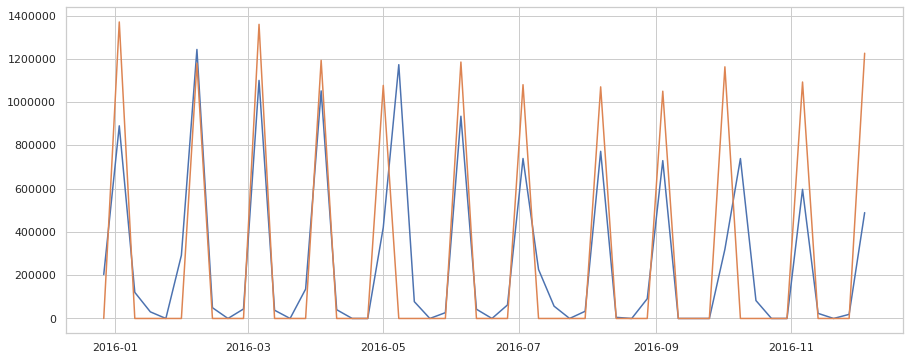

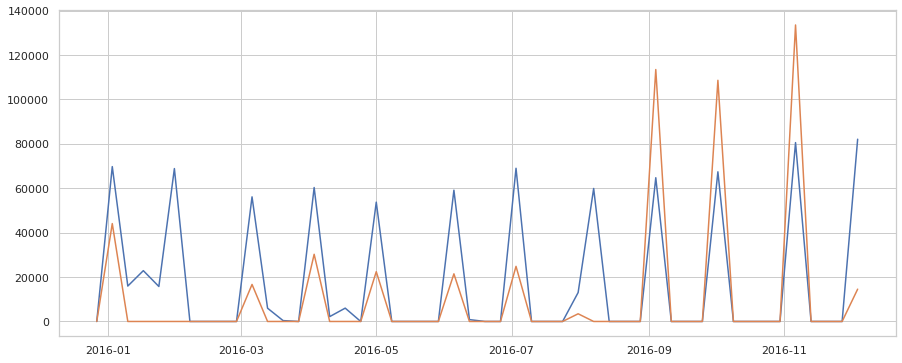

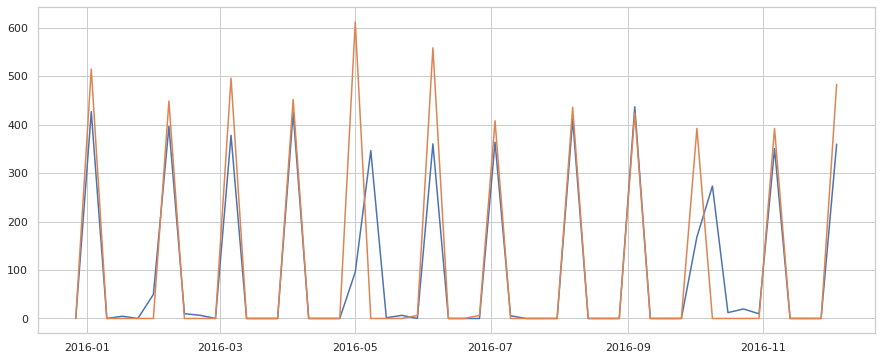

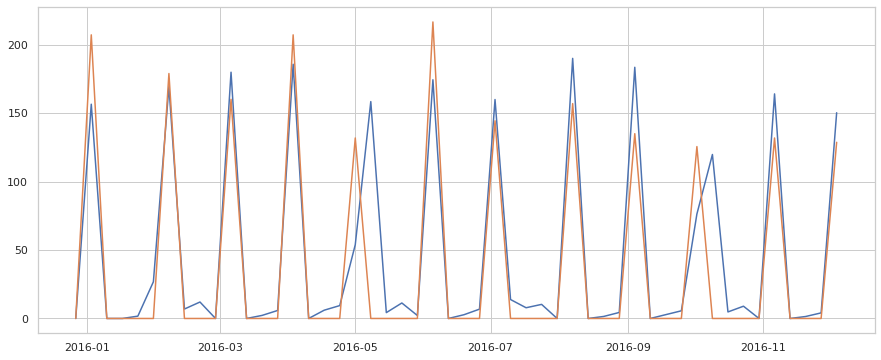

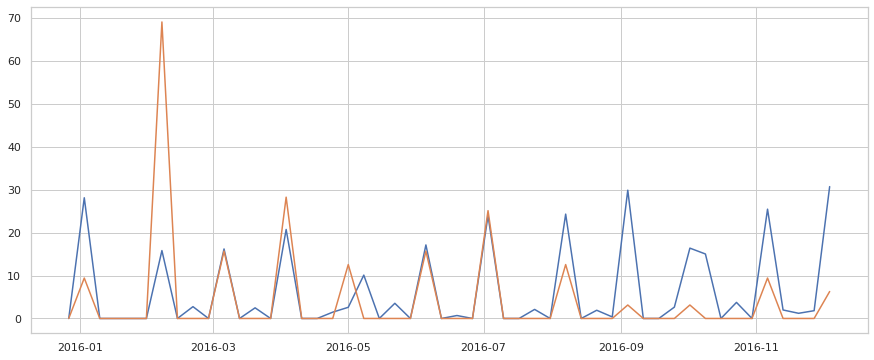

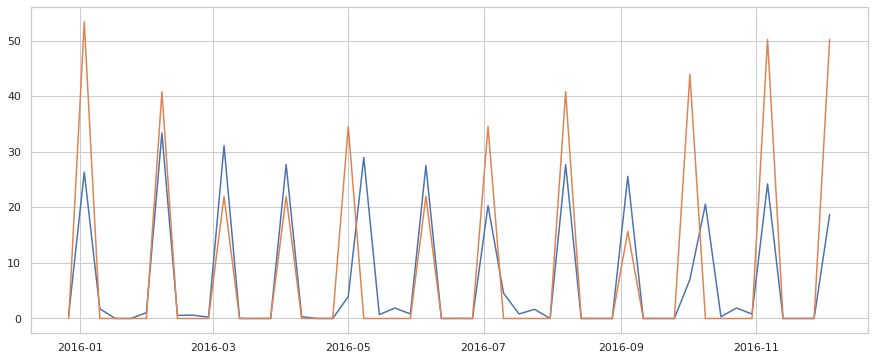

RMSE Total: 26653.934537967096


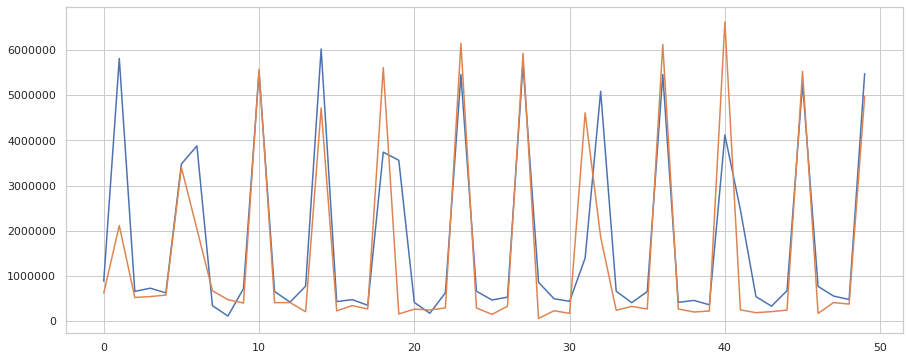

Last RMSE: 1185042.6537358162


In [37]:
sns.set(style="whitegrid")

pred= y_scaler.inverse_transform(y_test_predicted[0]).T
true = y_test[:horizon].T

t_pred = np.zeros(pred.shape[1])
t_true = np.zeros(true.shape[1])
t_rmse = 0

plotsize= (15,6)

bunch = [ "G00011","G00012","G00133","G00187","G00267","G00339","G00735","G00954"]

rnn = {}

for i in range(len(pred)):
    
    #if qtys[i][:-4] in bunch:
        plt.figure(figsize=plotsize)

        pred[i][pred[i] < 0] = 0

        rmse = np.sqrt(mean_squared_error(true[i], pred[i]))
        smapee = smape(pred[i], true[i])*100
        mae = mean_absolute_error(pred[i], true[i])
        #print("Product: " + qtys[i][:-4])
        #print("RMSE: ", rmse)
        #print("SMAPE: " +  str(np.round(smapee, decimals=2)) + "%")
        #print("MAE: " + str(mae))
        plt.plot(product[num_train:].index[:horizon], pred[i])
        plt.plot(product[num_train:].index[:horizon], true[i])
        plt.show()

        t_pred = t_pred + pred[i]
        t_true = t_true + true[i]
        t_rmse = t_rmse+rmse
        
        rnn[qtys[i][:-4]] = rmse
    
plt.figure(figsize=plotsize)
print("RMSE Total: " + str(t_rmse/len(pred)))
plt.plot(t_pred)
plt.plot(t_true)
plt.show()
rnn["total"] = t_rmse/len(pred)
print("Last RMSE: " + str(np.sqrt(mean_squared_error(t_true, t_pred))))

In [32]:
valsArr_old = [66.6851666549545, 67.88958611597897, 69.21681535327671, 66.48135020266528, 64.27709785778202, 60.72749709928205, 63.701465954928295, 65.17733810711289, 64.78680046203984, 54.03158148686864, 50.996898683969604, 54.064319848800224, 42.69338976116232, 7.7145067699141645, 58.73075744706745, 42.21435723311817, 65.8428871293241, 55.54466048398387, 37.459384554198074, 65.91935078588978, 59.44024944642978, 66.75112087030772, 55.109361656982436, 48.873453068349015, 46.018164004825145, 63.55124830274102, 58.51154392727636, 65.20080941236168, 20.582912304727387, 65.47745592815562, 29.05502729752538, 31.88538428636566, 66.19052965893539, 25.209622432309466, 65.30813282106377, 48.47010482324254, 55.35896540587586, 67.8970786052471, 63.95296694703776, 65.58669446483145, 69.07507501099678, 53.27732807353019, 59.13327495000382, 49.961020439339, 36.43109621690061, 58.25244506735996, 73.47924335249874, 48.24591638102002, 15.306627521117743, 54.619525753773665, 33.460658318138734, 63.38118223469059, 21.4684065315376, 51.57643764331531, 38.35348241078786, 57.49193432508641, 52.378319918141834, 3.2970115809005662, 45.070092238160676, 50.820191022437356, 20.009408502370174, 66.76133851423023, 15.381852603930446, 55.844775832748425, 63.3844295901193, 62.06249668996134, 18.796244866954524, 61.151276543758314, 69.76259052461357, 32.22915185003426, 52.164895526117284, 55.51180174042507]

In [33]:
valsArr = []
for f in naive:
    
    val = (1-(rnn[f]/naive[f]))*100
    #print(f + ": " + str(np.round(val,decimals=2)) + "%")
    valsArr.append(val)

In [34]:
print("Current : " + str(np.array(valsArr[:]).mean()))
print("Old: " +  str(np.array(valsArr_old[:]).mean()))

Current : 52.45785960365091
Old: 51.39896624210983


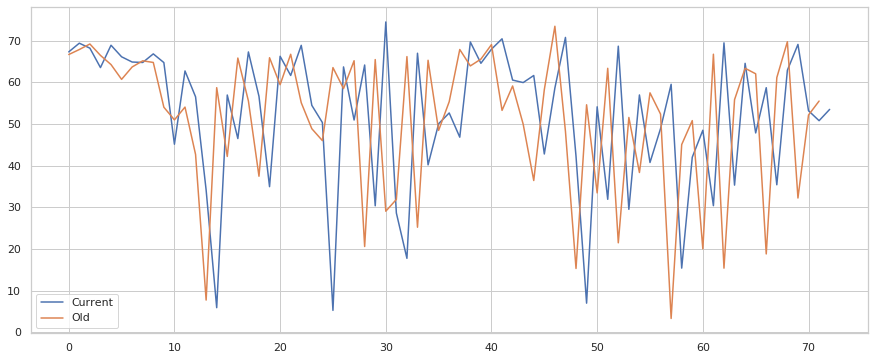

In [35]:
sns.set(style="whitegrid")

plt.figure(figsize=(15,6))
plt.plot(valsArr, label="Current")
plt.plot(valsArr_old, label="Old")
plt.legend()
plt.show()